<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Test_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating Test Data

## Import and Load Packages

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random
import jax.lax as lax

## Function Definitions

In [23]:
@jit
def squared_exp(i, j, tau, ell, sigma_f):
  return sigma_f**2.0*jnp.exp(-(tau[i]-tau[j])**2/(2*ell**2.0))

In [8]:
def cov_squared_exp(tau, ell, sigma_f):
  k = jnp.shape(tau)[0]
  covmat = jnp.empty((k,k)).astype(jnp.float32)
  for i in jnp.arange(k):
    for j in np.arange(k):
      covmat = covmat.at[i, j].set(squared_exp(i, j, tau, ell, sigma_f))
  return covmat

## Create Input, Filter and Noise

### Generate random number key

In [31]:
key = random.PRNGKey(0)

# Split key to get usable subkeys in case of future editing
key, *subkeys = random.split(key, 4)

### Make random input spike train

In [56]:
# Get subkey
subkeyx = subkeys[-1]

# Set up time indexing
Input_mt = 0.5
tbin_l = 0.005
K = jnp.floor(Input_mt/tbin_l).astype(jnp.int32)
timex = jnp.linspace(0.0, Input_mt, K+1)

inpx = random.bernoulli(subkeyx, 0.2, (K+1,1))

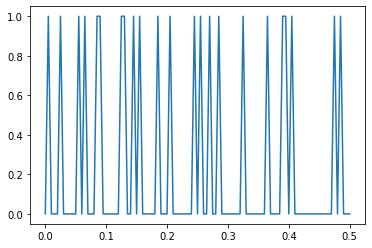

In [57]:
plt.plot(timex, inpx)

### Generate filter shape

In [63]:
# Get subkey
subkeyf = subkeys[-2]

# Set up time indexing
Filter_mt = 0.1
M = jnp.floor(Filter_mt/tbin_l).astype(jnp.int32)
timef = jnp.linspace(0.0, Filter_mt, M+1)

# True mean and covariance
muf_true = jnp.ones((M+1,1))
covf_true = cov_squared_exp(timef, 0.005 , 1.0)

# Generate filter from true mean and covariance
chol_true = jsc.linalg.cholesky(covf_true)
f_true = muf_true + chol_true@random.normal(subkeyf, (M+1,1))

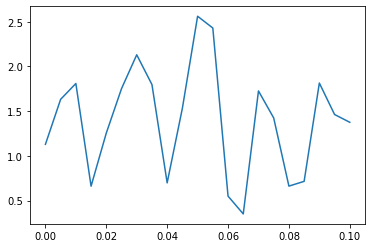

In [64]:
plt.plot(timef, f_true)

### Noise vector

In [60]:
# Get subkey 
subkeyn = subkeys[-3]

# Noise variance
sigma_n = 0.1

# Noise vector
noise_vec = sigma_n*random.normal(subkeyn, (M+K+1, 1))

## Generate Output

In [65]:
# Pad input and filter
xp_true = jnp.vstack((inpx, jnp.zeros((M,1))))
fp_true = jnp.vstack((f_true, jnp.zeros((K,1))))

# Compute the FFTs
X_true = jnp.fft.fft(xp_true)
F_true = jnp.fft.fft(fp_true)

# Elementwise multiplication
fftmul = jnp.multiply(X_true, F_true)

# Make output and time
y_true = jnp.real(jnp.fft.ifft(fftmul) + noise_vec)
timey = np.linspace(0, Input_mt+Filter_mt, K+M+1)

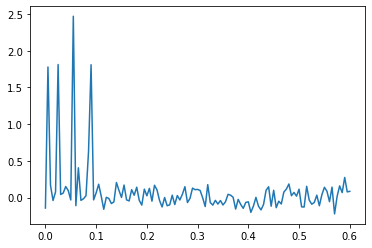

In [67]:
plt.plot(timey, y_true)